# Abstract

Bayesian pricing models are important.

In [1]:
#| echo: false

#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#| echo: false
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/yasserh/uber-fares-dataset")

In [49]:
#| echo: false

#Create dataframe from file
df = pd.read_csv("kaggle_datasets/uber-fares-dataset/uber.csv")

In [50]:
#Check dataframe
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [51]:
#| echo: false
#Rename unnamed column
df = df.rename(columns={'Unnamed: 0': 'id'})

In [52]:
#| echo: false
#Get summary statistics
df.describe()

,id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [53]:
#| echo: false
#See if there are any null values
df.isna().sum()

id                   0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [54]:
#| echo: false
#Drop null row(s)
df = df.dropna()

In [55]:
#Rename timestamp column
df = df.rename(columns={'key' : 'timestamp'})

In [56]:
#Check data types
df.dtypes

id                     int64
timestamp             object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [73]:
#Convert timestamp to a timestamp object
df['timestamp'] = (df['timestamp'].pipe(pd.to_datetime)
                   .dt.strftime('%Y-%m-%d %H:%M:%S')
                   .pipe(pd.to_datetime))

In [74]:
df['timestamp']

0        2015-05-07 19:52:06
1        2009-07-17 20:04:56
2        2009-08-24 21:45:00
3        2009-06-26 08:22:21
4        2014-08-28 17:47:00
                 ...        
199995   2012-10-28 10:49:00
199996   2014-03-14 01:09:00
199997   2009-06-29 00:42:00
199998   2015-05-20 14:56:25
199999   2010-05-15 04:08:00
Name: timestamp, Length: 199999, dtype: datetime64[ns]

# Exploratory Data Analysis

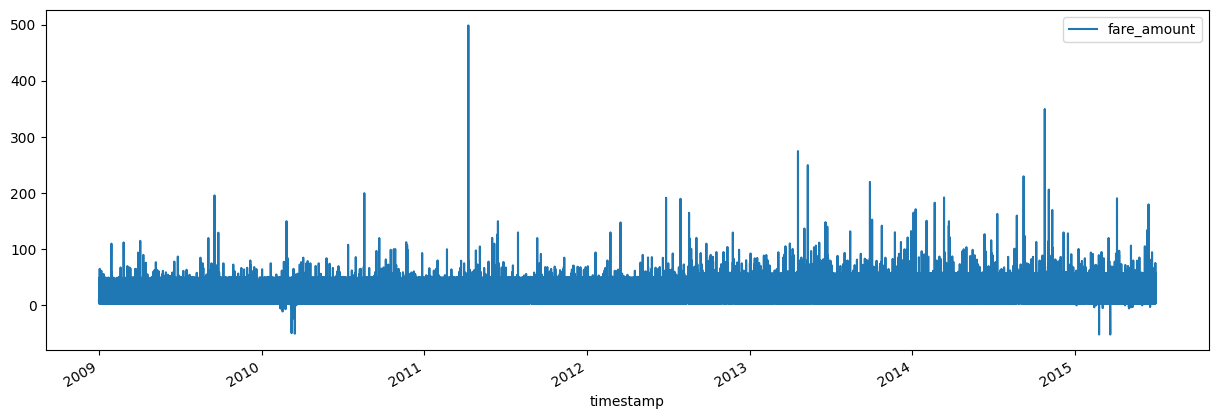

In [76]:
#Look at fare amount change over time
df.plot(x='timestamp', y = 'fare_amount', figsize=(15,5));